<a href="https://colab.research.google.com/github/Nerikoutchala/Nerikoutchala/blob/main/Clasificaci%C3%B3n_Til_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, let's import the necessary libraries, including PyTorch and the TIL MAPs dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

# Establecemos el dispositivo en GPU si está disponible, en caso contrario en CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definimos las transformaciones que se aplicarán a cada imagen del conjunto de datos
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el conjunto de datos TIL MAPs
til_maps_dataset = datasets.ImageFolder(root ='/content/drive/MyDrive/til_maps/TIL_maps_after_thres_v1/', transform=transform)

# Dividimos el conjunto de datos en conjuntos de entrenamiento y validación
train_size = int(0.8 * len(til_maps_dataset))
val_size = len(til_maps_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(til_maps_dataset, [train_size, val_size])

# Establecemos el tamaño del lote
batch_size = 32



# Creamos DataLoader para los conjuntos de entrenamiento y validación.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Visualización 

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Función para cargar las imágenes
def load_image(file):
    img = cv2.imread(til_maps_dataset + file, cv2.IMREAD_GRAYSCALE)
    return img


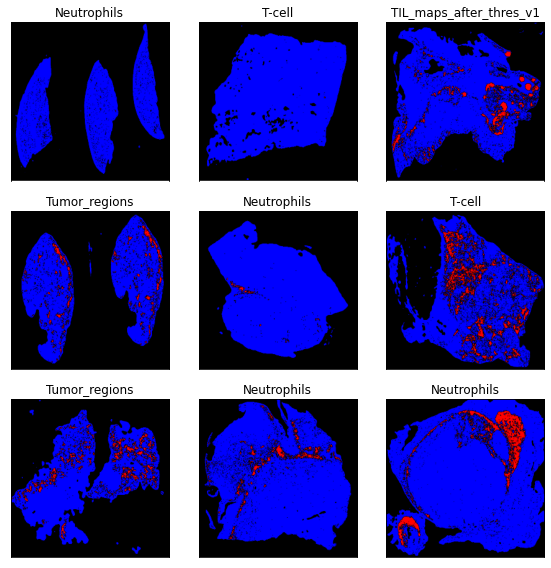

In [ ]:
# Mapeo de categorías a nombres
class_names = {0: 'Other', 1: 'T-cell', 2: 'B-cell', 3: 'TIL_maps_after_thres_v1', 
               4: 'TIL_maps_before_thres_v1', 5: 'Tumor_regions', 6: 'Epithelial', 
               7: 'Stromal', 8: 'Inflammatory', 9: 'Neutrophils', 10: 'Plasma cells', 
               11: 'Macrophages'}


# Seleccionamos algunas imágenes aleatorias de los datos de entrenamiento
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(len(train_dataset))
    img, label = train_dataset[idx]
    img = img.permute(1, 2, 0)  # Reorder dimensions from (C, H, W) to (H, W, C)
    ax.imshow(img, cmap='gray')
    ax.set_title(class_names[label])
    
plt.tight_layout()
plt.show()


Definimos el modelo

A continuación, voy a definir el modelo de aprendizaje profundo que voy a utilizar para la clasificación. Para ello, utilizaré una red neuronal convolucional (CNN) simple con tres capas convolucionales, seguidas de dos capas totalmente conectadas (lineales).

In [ ]:
class TILClassifier(nn.Module):
    def __init__(self):
        super(TILClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(64 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        print('1', x.shape)
        x = nn.functional.relu(self.conv1(x))
        print('2', x.shape)
        x = nn.functional.max_pool2d(x, 2)
        print('3', x.shape)
        x = nn.functional.relu(self.conv2(x))
        print('4', x.shape)
        x = nn.functional.max_pool2d(x, 2)
        print('5', x.shape)
        x = nn.functional.relu(self.conv3(x))
        print('6', x.shape)
        x = nn.functional.max_pool2d(x, 2)
        print('7', x.shape)
        x = x.view(-1, 64 * 64 * 64)
        print('8', x.shape)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)


In [ ]:
class DoubleConv(nn.Module):
    '''
    |------|    |------|    |------|    |------|    |------|    |------|
    | Conv | => | [BN] | => | ReLU | => | Conv | => | [BN] | => | ReLU |
    |------|    |------|    |------|    |------|    |------|    |------|
    '''
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            # One
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # Two
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            # Use the previous block
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # Notice the two inputs:
        # - x1 (the data from the previous block, goes through the green arrow)
        # - x2 (the data from the equivalent layer of the encoding path, goes through the gray arrow)
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Fix size issues to match dimensions of x1 and x2 arrays
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenate both arrays
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoding leg
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        # Decoding leg
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x) # inut conv
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x) # output conv
        return logits

Definimos la función de pérdida y el optimizador

A continuación, voy a definir la función de pérdida y el optimizador que utilizaremos para entrenar el modelo. Para este ejemplo, utilizare la Cross Entropy Loss y el optimizador Adam.

In [ ]:
# Definimos la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss() 

#Esta función de pérdida calcula la diferencia entre dos distribuciones de probabilidad 
#distribuciones para un conjunto proporcionado de ocurrencias o variables aleatorias.

#model = TILClassifier()
model = UNet(3, 3).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)


Entrenamos el modelo

Ahora entrenamos el modelo. Hare un bucle sobre los datos de entrenamiento en lotes, pasaremos las imágenes a través del modelo para obtener las probabilidades de clase predichas, calcularemos la pérdida entre las clases predichas y las reales, y retropropagaremos la pérdida para actualizar los pesos del modelo. También evaluaremos el modelo en el conjunto de validación después de cada época para controlar su progreso.

In [ ]:
# Definimos el número de épocas para entrenar
num_epochs = 30

# Entrenamos el modelo
for epoch in range(num_epochs):
    # Ponemos el modelo en modo entrenamiento
    model.train()

    # Recorremos los datos de entrenamiento por lotes
    for i, (inputs, labels) in enumerate(train_loader):
        # Movemos las entradas y las etiquetas al dispositivo
        inputs, labels = inputs.to(device), labels.to(device)

        # Ponemos a cero los gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculamos la pérdida
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Actualizamos las ponderaciones
        optimizer.step()

        # Print the loss every 10 batches
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print the validation accuracy
        print('Epoch [{}/{}], Validation Accuracy: {:.2f}%'
              .format(epoch+1, num_epochs, 100 * correct / total))


NameError: ignored

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx}: input shape = {data.shape}, target shape = {target.shape}")


Batch 0: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 1: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 2: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 3: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 4: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 5: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 6: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 7: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 8: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 9: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 10: input shape = torch.Size([32, 3, 256, 256]), target shape = torch.Size([32])
Batch 11: input shape = torch.Size([32, 3, 256, 256])

Test the Model

Finally, we can test the model on a set of images it has not seen before to evaluate its performance.

In [ ]:
# Set the model to evaluation mode
model.eval()

# Load the test set
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/til_maps/TIL_maps_before_thres_v1/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Evaluate the model on the test set
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print the test accuracy
    print('Test Accuracy: {:.2f}%'.format(100 * correct / total))
